## Classification analysis, using PyTorch

This program is used only as a comparison for the hand-written implementation version at `code/exercise_2f.ipynb`.

**NOTE**: The code in this notebook takes a long time to run. Therefore, we have saved the results to files after running it once. 
You can load the results from the file directly instead of running the code again by setting the below `LOAD_FROM_FILE` variable to `True`.

In [1]:
LOAD_FROM_FILE = True

In [2]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from utils.utils import get_MNIST_dataset, onehot_decode_mnist_labels, show_images, skip_if
from sklearn.model_selection import train_test_split

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


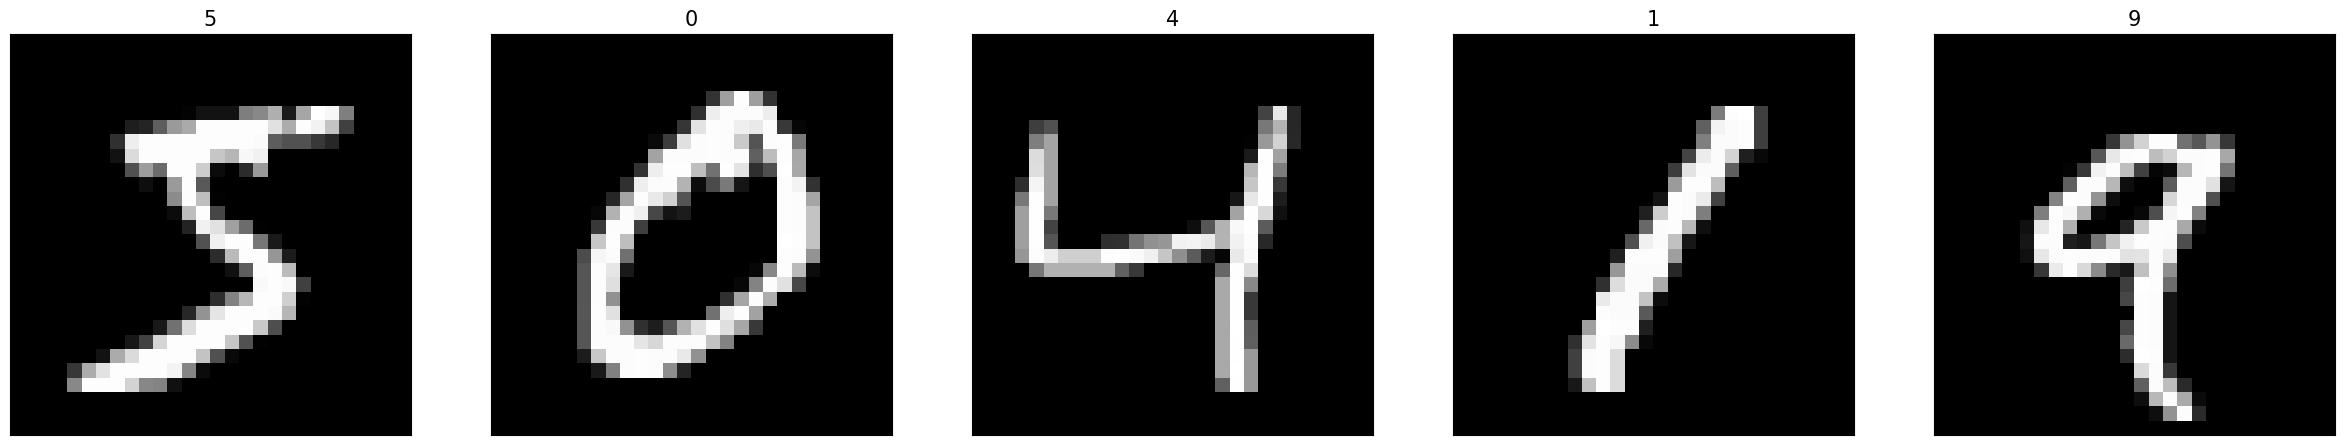

In [4]:
# Load MNIST dataset
X, y = get_MNIST_dataset()
y = onehot_decode_mnist_labels(y)
show_images(X[:5], y[:5])

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
class NN_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.sequence = nn.Sequential(
            nn.Linear(X.shape[1], 256),
            nn.Sigmoid(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        logits = self.sequence(x)
        return logits

In [7]:
def accuracy(model):
    model.eval()  # set model to evaluation mode 
    correct = 0
    total = 0
    with torch.no_grad():  # disable gradient calculation for evaluation 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)  # class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [8]:
def train_model(model, lr=0.01, num_epochs=10, lambd=1e-4):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lambd)
    for _ in range(num_epochs):
        model.train()  # set model to training mode
        for images, labels in train_loader:
            # Move data to device (GPU if available, else CPU)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()            # reset gradients to zero
            outputs = model(images)          # forward pass: compute predictions
            loss = criterion(outputs, labels)  # compute cross-entropy loss
            loss.backward()                 # backpropagate to compute gradients
            optimizer.step()                # update weights using SGD step 

    return accuracy(model)

In [9]:
learning_rates = np.logspace(-1, 1, 5)
lambdas = np.logspace(-10, -5, 6)

In [10]:
%%skip_if LOAD_FROM_FILE
accuracies = np.zeros((len(learning_rates), len(lambdas)))
for i, lr in enumerate(learning_rates):
    for j, lambd in enumerate(lambdas):
        print(f"Training with learning rate: {lr} and lambda: {lambd}")
        torch.manual_seed(124)
        model = NN_model().to(device)
        acc = train_model(model, lr=lr, num_epochs=5, lambd=lambd)
        accuracies[i,j] = acc

In [11]:
filepath = "../data/nn_lambda_vs_lr_final_torch.npy"

# Save data to file
# np.save(filepath, accuracies)

# Load data from file
if LOAD_FROM_FILE:
    accuracies = np.load(filepath)

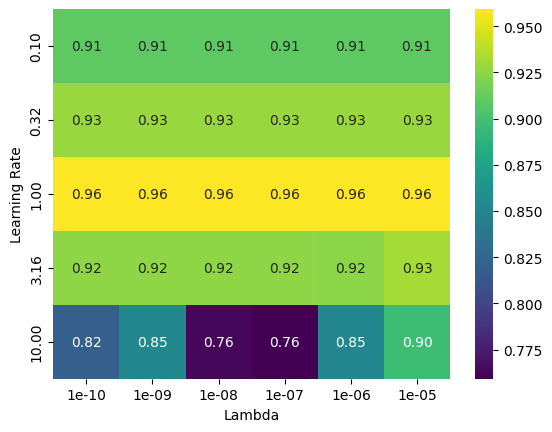

In [12]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Heatmap
sns.heatmap(
    accuracies,
    fmt=".2f",
    annot=True,
    cmap="viridis",
    xticklabels=list(map(lambda x: f"{x:.0e}", lambdas)),
    yticklabels=list(map(lambda x: f"{x:.2f}", learning_rates)),

)
plt.xlabel("Lambda")
plt.ylabel("Learning Rate")
plt.show()

In [13]:
best_lr_idx, best_lambd_idx = np.unravel_index(np.argmax(accuracies), accuracies.shape)
best_lr = learning_rates[best_lr_idx]
best_lambd = lambdas[best_lambd_idx]
print(f"Best accuracy: {accuracies[best_lr_idx, best_lambd_idx]:.3f} with learning rate={best_lr}, lambda={best_lambd}")

Best accuracy: 0.959 with learning rate=1.0, lambda=1e-10


## Comparing number of hidden layers and nodes per layer
- Using best combination of learning rate and regularization parameter lambda found above

In [14]:
def train_layers_nodes(n_layers, n_nodes, activation_func=nn.Sigmoid(), num_epochs=3):
    model = NN_model().to(device)
    hidden_layers = []
    for _ in range(n_layers-1):
        hidden_layers.append(nn.Linear(n_nodes, n_nodes))
        hidden_layers.append(activation_func)

    model.sequence = nn.Sequential(
            nn.Linear(X.shape[1], n_nodes),
            activation_func,
            *hidden_layers,
            nn.Linear(n_nodes, 10)
        ).to(device)

    print(f"Training model with {n_layers} hidden layers, and {n_nodes} nodes per layer")

    return train_model(model, lr=best_lr, num_epochs=num_epochs, lambd=best_lambd)

In [15]:
n_layers_list = [1, 2, 3]
n_nodes_list = [32, 64, 128, 256, 512]

In [16]:
%%skip_if LOAD_FROM_FILE

layers_nodes_accuracy = np.zeros((len(n_layers_list), len(n_nodes_list)))
for i, n_layers in enumerate(n_layers_list):
    for j, n_nodes in enumerate(n_nodes_list):
        torch.manual_seed(124)
        layers_nodes_accuracy[i,j] = train_layers_nodes(n_layers, n_nodes, num_epochs=5)

In [17]:
filepath = "../data/nodes_vs_layers_final_torch.npy"
# np.save(filepath, layers_nodes_accuracy)
if LOAD_FROM_FILE:
    layers_nodes_accuracy = np.load(filepath)

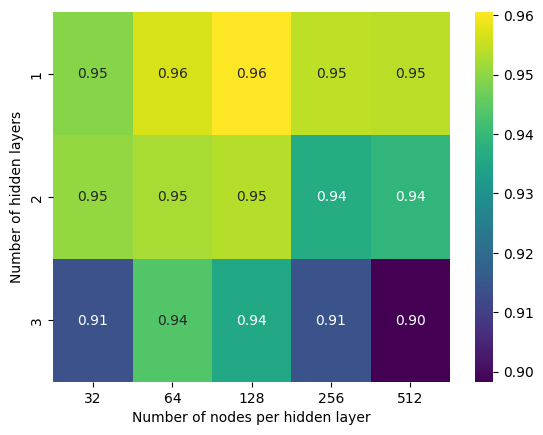

In [18]:
# Heatmap of number of layers vs number of nodes
sns.heatmap(
    layers_nodes_accuracy,
    fmt=".2f",
    annot=True,
    cmap="viridis",
    xticklabels=n_nodes_list,
    yticklabels=n_layers_list,
)
plt.xlabel("Number of nodes per hidden layer")
plt.ylabel("Number of hidden layers")
plt.savefig("../figs/nodes_vs_layers_heatmap.pdf")
plt.show()

In [19]:
best_n_layers_idx, best_n_nodes_idx = np.unravel_index(np.argmax(layers_nodes_accuracy), layers_nodes_accuracy.shape)
best_n_layers = n_layers_list[best_n_layers_idx]
best_n_nodes = n_nodes_list[best_n_nodes_idx]
print(f"Best accuracy: {layers_nodes_accuracy[best_n_layers_idx, best_n_nodes_idx]:.4f} with {best_n_layers} hidden layers, {best_n_nodes} nodes per layer")

Best accuracy: 0.9605 with 1 hidden layers, 128 nodes per layer


## Comparing activation functions ReLU, LeakyReLU, Sigmoid

In [20]:
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid()]
num_epochs = 10

In [21]:
%%skip_if LOAD_FROM_FILE
activation_accuracies = np.zeros(len(activation_functions))
for i, activation_func in enumerate(activation_functions):
    # Model with best parameters found
    torch.manual_seed(124)
    activation_accuracies[i] = train_layers_nodes(best_n_layers, best_n_nodes, activation_func=activation_func, num_epochs=num_epochs)

In [22]:
filepath = "../data/activation_functions_comparison_final_torch.npy"
# np.save(filepath, activation_accuracies)
if LOAD_FROM_FILE:
    activation_accuracies = np.load(filepath)

In [23]:
print(f"Final accuracies after {num_epochs} epochs:")
for i, activation_func in enumerate(activation_functions):
    print(f"\t{type(activation_func).__name__:10}: {activation_accuracies[i]:.4f}")


Final accuracies after 10 epochs:
	ReLU      : 0.9701
	LeakyReLU : 0.9712
	Sigmoid   : 0.9687


We see that the LeakyReLU activation function gives the best accuracy, rising to about 97.12% after 10 epochs.

## Training a model with the best found parameters
We train this model for 50 epochs to see how well it performs.

In [24]:
num_epochs_final = 50

In [25]:
%%skip_if LOAD_FROM_FILE
torch.manual_seed(124)
final_accuracy = train_layers_nodes(best_n_layers, best_n_nodes, activation_func=nn.LeakyReLU(),num_epochs=num_epochs_final)

In [26]:
filepath = "../data/best_model_accuracy_final_torch.npy"
# np.save(filepath, final_accuracy)
if LOAD_FROM_FILE:
    final_accuracy = np.load(filepath)

In [27]:
print(f"Final accuracy after {num_epochs_final} epochs: {final_accuracy:.4f}")

Final accuracy after 50 epochs: 0.9760
